<div class="alert alert-block alert-info">

# Import libraries and data

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

In [2]:
price_df = pd.read_csv('Data/price.csv')
pricepersqft_df = pd.read_csv('Data/pricepersqft.csv')
price_df.head()

,City Code,City,Metro,County,State,Population Rank,November 2010,December 2010,January 2011,February 2011,...,April 2016,May 2016,June 2016,July 2016,August 2016,September 2016,October 2016,November 2016,December 2016,January 2017
0,6181,New York,New York,Queens,NY,1,NaN,NaN,NaN,NaN,...,2334,2339,2345,2344,2336,2324,2318,2321,2321,2322
1,12447,Los Angeles,Los Angeles,Los Angeles,CA,2,2184.0,2184.0,2183.0,2188.0,...,2637,2662,2687,2704,2716,2723,2731,2740,2748,2753
2,17426,Chicago,Chicago,Cook,IL,3,1563.0,1555.0,1547.0,1537.0,...,1684,1686,1687,1685,1681,1675,1668,1656,1644,1632
3,39051,Houston,Houston,Harris,TX,4,1198.0,1199.0,1199.0,1200.0,...,1444,1446,1446,1443,1440,1438,1437,1437,1435,1430
4,13271,Philadelphia,Philadelphia,Philadelphia,PA,5,1092.0,1099.0,1094.0,1087.0,...,1206,1211,1218,1222,1223,1220,1216,1211,1209,1212


<div class="alert alert-block alert-info">

# Look for a Particular City

### Select a city

In [3]:
# Check to see if the city is in the dataframe

city = "Phoenix"
check = price_df['City'].unique()
city in check

True

### Does the city only appear once?

In [4]:
# Inspect the df to make sure there's one row

price_df.loc[price_df['City'] == city]

,City Code,City,Metro,County,State,Population Rank,November 2010,December 2010,January 2011,February 2011,...,April 2016,May 2016,June 2016,July 2016,August 2016,September 2016,October 2016,November 2016,December 2016,January 2017
5,40326,Phoenix,Phoenix,Maricopa,AZ,6,1087.0,1080.0,1071.0,1067.0,...,1228,1236,1240,1240,1238,1238,1239,1241,1244,1247
5920,36028,Phoenix,Baltimore,Baltimore,MD,5921,2678.0,2676.0,2646.0,2617.0,...,2608,2592,2589,2593,2595,2592,2587,2579,2571,2566
7010,47087,Phoenix,Medford,Jackson,OR,7011,1003.0,1006.0,1002.0,997.0,...,1341,1366,1380,1382,1370,1358,1355,1359,1370,1380
8981,33407,Phoenix,Syracuse,Oswego,NY,8982,1209.0,1229.0,1247.0,1251.0,...,1233,1231,1226,1211,1189,1172,1168,1175,1160,1141
10526,26480,Phoenix,Chicago,Cook,IL,10527,1203.0,1195.0,1173.0,1157.0,...,1182,1194,1210,1225,1234,1239,1247,1245,1245,1238


### Prep the city's data

In [5]:
# Get the index of the city
city_index = price_df.index[price_df['City'] == city][0]

# Flip the dimensions of the dataframe
city_df = price_df.loc[city_index].transpose()

# Create the time column
monthly_intervals = pd.date_range('2010-11', periods=75, freq='M')

# Drop unnecessary columns 
city_df = city_df.drop(['City Code', 'City','Metro','County','State','Population Rank'], axis=0)
city_df = city_df.to_frame()

# Add the time column and set it as the index
city_df['Time'] = monthly_intervals.values
city_df = city_df.set_index('Time')

# Rename the Price column
city_df['Price'] = city_df[city_index]
city_df = city_df.drop([city_index], axis = 1)

# Create a list of prices.  This will be used to create the log column
city_prices = list(city_df['Price'])

<div class="alert alert-block alert-info">

# Stationarity Check Function

We will be using this function to check the stationarity of our data by performing a Dickie Fuller Test

In [6]:
def stationarity_check(TS):

    # Calculate rolling statistics
    rolmean = TS.rolling(window = 12, center = False).mean()
    rolstd = TS.rolling(window = 12, center = False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS) 
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print ('Results of Dickey-Fuller Test:')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    return None

<div class="alert alert-block alert-info">

# Transformations

### Look for which transformation has the lowest test statistic

Log_Scale


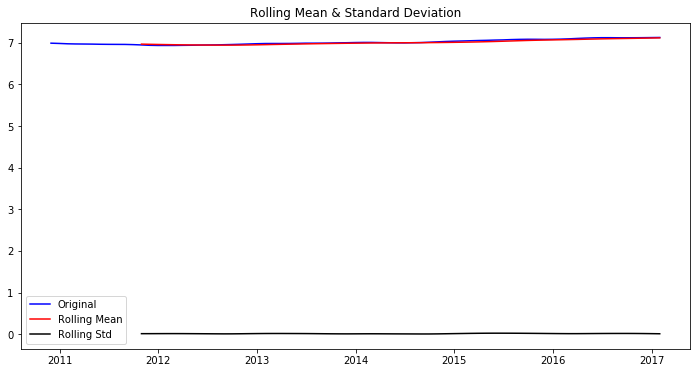

Results of Dickey-Fuller Test:
Test Statistic                  0.675305
p-value                         0.989332
#Lags Used                      3.000000
Number of Observations Used    71.000000
Critical Value (1%)            -3.526005
Critical Value (5%)            -2.903200
Critical Value (10%)           -2.588995
dtype: float64

First_Difference


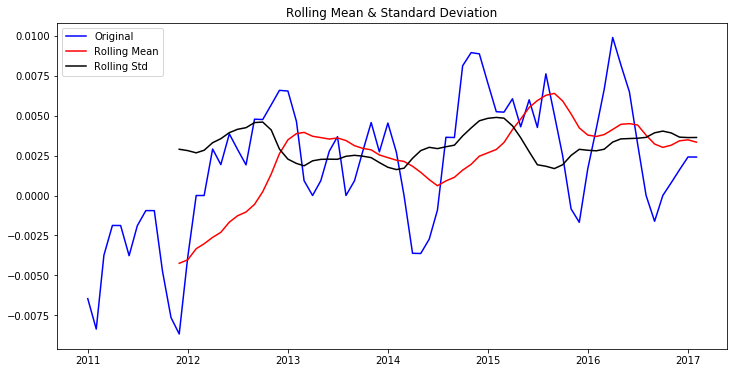

Results of Dickey-Fuller Test:
Test Statistic                 -3.587680
p-value                         0.006001
#Lags Used                      2.000000
Number of Observations Used    71.000000
Critical Value (1%)            -3.526005
Critical Value (5%)            -2.903200
Critical Value (10%)           -2.588995
dtype: float64

Rolling_Avg


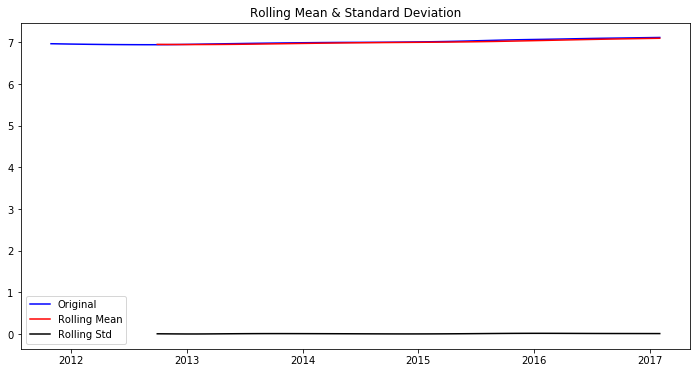

Results of Dickey-Fuller Test:
Test Statistic                  0.478827
p-value                         0.984215
#Lags Used                      5.000000
Number of Observations Used    58.000000
Critical Value (1%)            -3.548494
Critical Value (5%)            -2.912837
Critical Value (10%)           -2.594129
dtype: float64

Log_Sub_Rolling


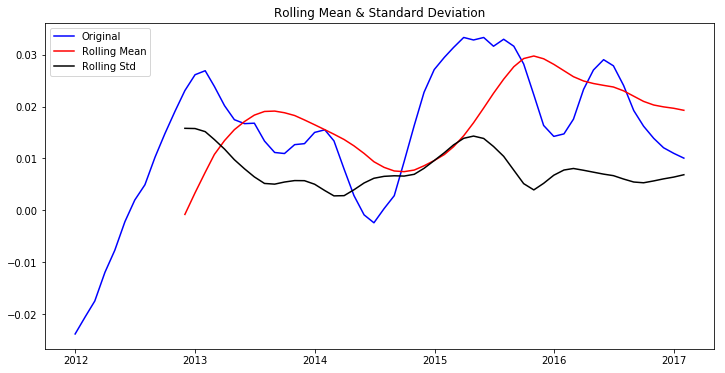

Results of Dickey-Fuller Test:
Test Statistic                 -2.740936
p-value                         0.067218
#Lags Used                      3.000000
Number of Observations Used    58.000000
Critical Value (1%)            -3.548494
Critical Value (5%)            -2.912837
Critical Value (10%)           -2.594129
dtype: float64

Exp_Weight_Avg


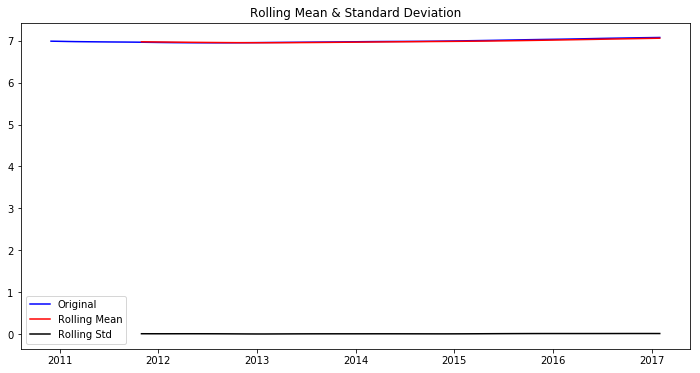

Results of Dickey-Fuller Test:
Test Statistic                 -0.878036
p-value                         0.795119
#Lags Used                      3.000000
Number of Observations Used    71.000000
Critical Value (1%)            -3.526005
Critical Value (5%)            -2.903200
Critical Value (10%)           -2.588995
dtype: float64

Log_Sub_Exp


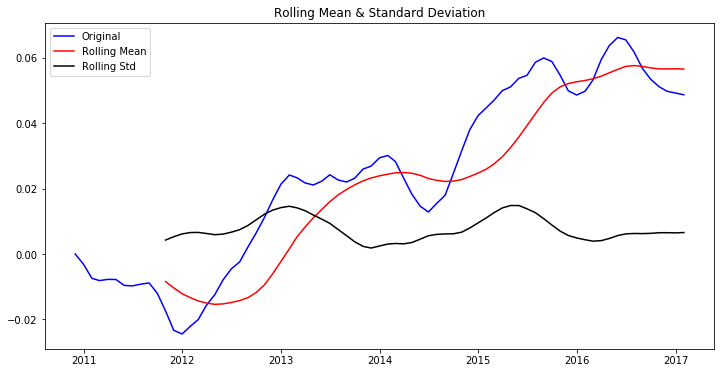

Results of Dickey-Fuller Test:
Test Statistic                 -0.867751
p-value                         0.798407
#Lags Used                      3.000000
Number of Observations Used    71.000000
Critical Value (1%)            -3.526005
Critical Value (5%)            -2.903200
Critical Value (10%)           -2.588995
dtype: float64

Log_Sub_Exp_Shift


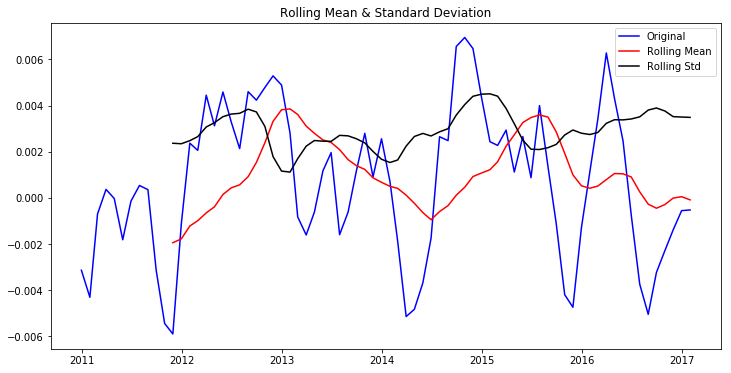

Results of Dickey-Fuller Test:
Test Statistic                 -4.569055
p-value                         0.000147
#Lags Used                      2.000000
Number of Observations Used    71.000000
Critical Value (1%)            -3.526005
Critical Value (5%)            -2.903200
Critical Value (10%)           -2.588995
dtype: float64

Log_Sub_Roll_Shift


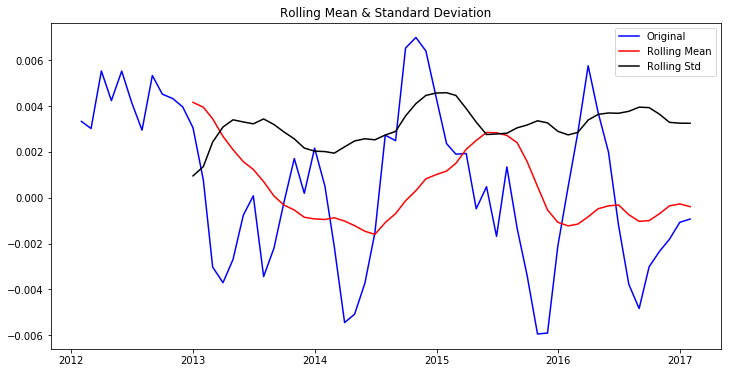

Results of Dickey-Fuller Test:
Test Statistic                 -4.193882
p-value                         0.000675
#Lags Used                      2.000000
Number of Observations Used    58.000000
Critical Value (1%)            -3.548494
Critical Value (5%)            -2.912837
Critical Value (10%)           -2.594129
dtype: float64


In [7]:
print('Log_Scale')
city_df['Log_Scale'] = np.log(city_prices)
stationarity_check(city_df.Log_Scale.dropna(inplace=False))

print('')
print('First_Difference')
city_df['First_Difference'] = city_df['Log_Scale'] - city_df['Log_Scale'].shift(1)
stationarity_check(city_df['First_Difference'].dropna(inplace=False) )

print('')
print('Rolling_Avg')
city_df['Rolling_Avg'] = city_df['Log_Scale'].rolling(window = 12).mean()
stationarity_check(city_df.Rolling_Avg.dropna(inplace=False))

print('')
print('Log_Sub_Rolling')
city_df['Log_Sub_Rolling'] = city_df['Log_Scale'][13:] - city_df['Rolling_Avg'][13:]
stationarity_check(city_df.Log_Sub_Rolling.dropna(inplace=False))

print('')
print('Exp_Weight_Avg')
city_df['Exp_Weight_Avg'] = city_df['Log_Scale'].ewm(halflife = 12, min_periods = 0, adjust = True).mean()
stationarity_check(city_df.Exp_Weight_Avg.dropna(inplace=False))

print('')
print('Log_Sub_Exp')
city_df['Log_Sub_Exp'] = city_df['Log_Scale'] - city_df['Exp_Weight_Avg']
stationarity_check(city_df.Log_Sub_Exp.dropna(inplace=False))

print('')
print('Log_Sub_Exp_Shift')
city_df['Log_Sub_Exp_Shift'] = city_df['Log_Sub_Exp'] - city_df['Log_Sub_Exp'].shift(1)
stationarity_check(city_df.Log_Sub_Exp_Shift.dropna(inplace=False))

print('')
print('Log_Sub_Roll_Shift')
city_df['Log_Sub_Roll_Shift'] = city_df['Log_Sub_Rolling'] - city_df['Log_Sub_Rolling'].shift(1)
stationarity_check(city_df.Log_Sub_Roll_Shift.dropna(inplace=False))

<div class="alert alert-block alert-info">

# Plot ACF and PACF graphs to get Q and P values

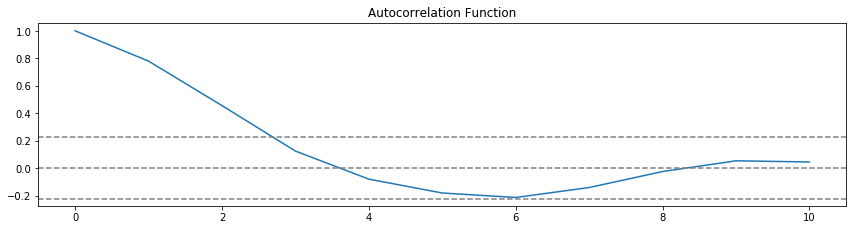

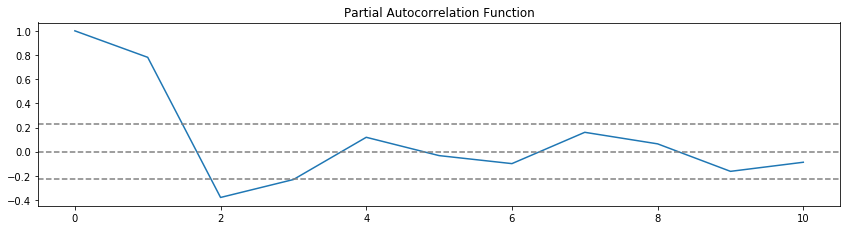

In [8]:
from statsmodels.tsa.stattools import acf, pacf

# ACF and PACF plots:
# We use the column that produced the best stationarity

### This is a section that needs to be fill out: ### 

best_dickie_fuller = 'Log_Sub_Exp_Shift'

city_df[best_dickie_fuller].dropna(inplace = True)
lag_acf = acf(city_df[best_dickie_fuller], nlags=10)
lag_pacf = pacf(city_df[best_dickie_fuller], nlags=10, method='ols')


#Plot ACF: 
plt.figure(figsize = (12,6))
plt.subplot(211) 

plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(74),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(74),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.tight_layout()

#Plot PACF:
plt.figure(figsize = (12,6))
plt.subplot(212)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(74),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(74),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

<div class="alert alert-block alert-info">

# Build the ARIMA Model

When modeling, we model against the Log Scale and tune the parameters based on the ACF and PACF graphs

In [9]:
# We model against the Log Scale
X = city_df['Log_Scale']

# How big do we want our test set?
size = int(len(X) * 0.66)

# Train, Test, Split
train, test = X[0:size], X[size:len(X)]

# Want just a list of the training values, no time attached
history = [x for x in train]

# print each prediction
predictions = []
for t in range(len(test)):
    model = ARIMA(history, order=(4,2,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted = %f, expected = %f, absolute difference = %f' % (yhat, obs, (abs(yhat - obs))))
error = mean_squared_error(test, predictions)
print('Test MSE: %.9f' % error)

predicted = 7.039770, expected = 7.038784, absolute difference = 0.000986
predicted = 7.045550, expected = 7.044033, absolute difference = 0.001517
predicted = 7.049214, expected = 7.049255, absolute difference = 0.000041
predicted = 7.055234, expected = 7.055313, absolute difference = 0.000079
predicted = 7.062317, expected = 7.059618, absolute difference = 0.002700
predicted = 7.063808, expected = 7.065613, absolute difference = 0.001805
predicted = 7.071916, expected = 7.069874, absolute difference = 0.002042
predicted = 7.074552, expected = 7.077498, absolute difference = 0.002946
predicted = 7.085252, expected = 7.082549, absolute difference = 0.002704
predicted = 7.088389, expected = 7.085064, absolute difference = 0.003325
predicted = 7.086425, expected = 7.084226, absolute difference = 0.002199
predicted = 7.083694, expected = 7.082549, absolute difference = 0.001146
predicted = 7.081408, expected = 7.084226, absolute difference = 0.002818
predicted = 7.087684, expected = 7.088

In [10]:
# Create predictions
predicts = []

# Convert the predicted log values to rental prices
for i in predictions:
    predicts.extend(np.exp(i))

# Convert the expected log value to rental prices
expects = test.tolist()
expects_median = []
for i in expects:
    expects_median.append(np.exp(i))


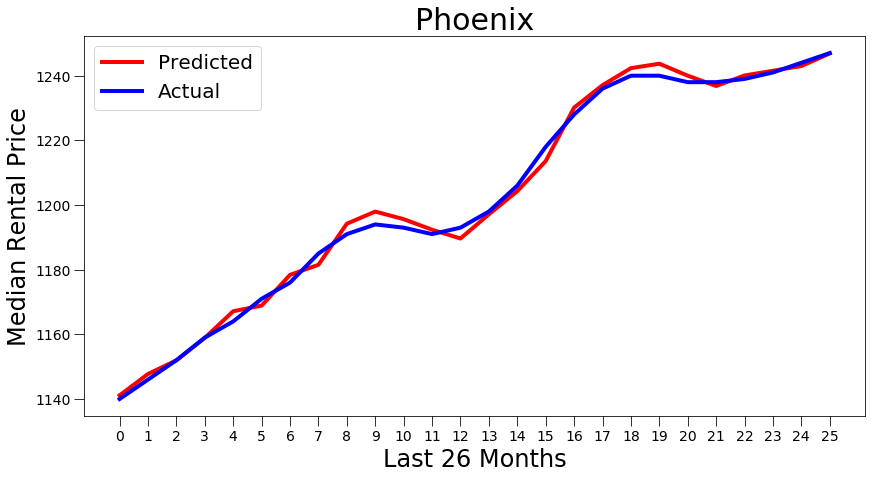

In [11]:
# Graph the expected and the predicted values

plt.figure(figsize = (14,7))
x = np.arange(0, 26, 1)
# create an index for each tick position
xi = [i for i in range(0, len(x))]
y = predicts
z = expects_median
plt.plot(xi, y, linestyle='-', color='r', label='Predicted', linewidth=4.0)
plt.plot(xi, z, linestyle='-', color='b', label='Actual', linewidth=4.0) 
plt.xlabel('Last 26 Months', fontsize=24)
plt.ylabel('Median Rental Price', fontsize=24) 
plt.xticks(xi, x,)
plt.tick_params('x', colors='black', size = 10, labelsize = 14)
plt.tick_params('y', colors='black', size = 10, labelsize = 14)
plt.title(city, fontsize=30)
plt.legend(prop={'size': 20}) 
plt.show()

<div class="alert alert-block alert-info">

# MAPE and Mean Squared Error

In [12]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    print('Mape = ' + str(np.mean(np.abs((y_true - y_pred) / y_true)) * 100))
mean_absolute_percentage_error(expects_median, predicts)
print('MSE = ' + str(mean_squared_error(expects_median, predicts)))

Mape = 0.16281585380715696
MSE = 5.3390244958076405


<div class="alert alert-block alert-info">

# Predicting the next year

In [13]:
# Get the foecast for the nex 12 mntohs
forecast = model_fit.forecast(steps = 12)

# Next 12 month predictions
next_12_months = forecast[0].tolist()
next_year = []
for i in next_12_months:
    next_year.append(np.exp(i))
next_year

[1246.8884700449294,
 1249.5586823964823,
 1251.8970850126975,
 1254.2065504609784,
 1256.694030273449,
 1259.4718534744673,
 1262.5021280227113,
 1265.6918373241167,
 1268.9636756204743,
 1272.2944483518559,
 1275.7063055239626,
 1279.2363192349321]

In [14]:
# Upper Confidence Boundry
forecast = model_fit.forecast(steps = 12)
next_12_months = (forecast[0] + forecast[1]).tolist()
upper_ci = []
for i in next_12_months:
    upper_ci.append(np.exp(i))
upper_ci

[1249.4528641199847,
 1255.7659066593308,
 1262.900027709536,
 1270.4041649362168,
 1278.2214632823543,
 1286.4102560561405,
 1295.068096789377,
 1304.2593626711446,
 1314.0052583297008,
 1324.2959782303892,
 1335.1108068792526,
 1346.4341910411658]

In [15]:
# Lower Confidence Boundry
forecast = model_fit.forecast(steps = 12)
next_12_months = (forecast[0] - forecast[1]).tolist()
lower_ci = []
for i in next_12_months:
    lower_ci.append(np.exp(i))
lower_ci

[1244.3293391671991,
 1243.382140311614,
 1240.9900048111742,
 1238.2154550777973,
 1235.5291560114158,
 1233.097561393496,
 1230.7550677940142,
 1228.2647707339634,
 1225.4660320698556,
 1222.3348782422568,
 1218.9449516610664,
 1215.392160521646]

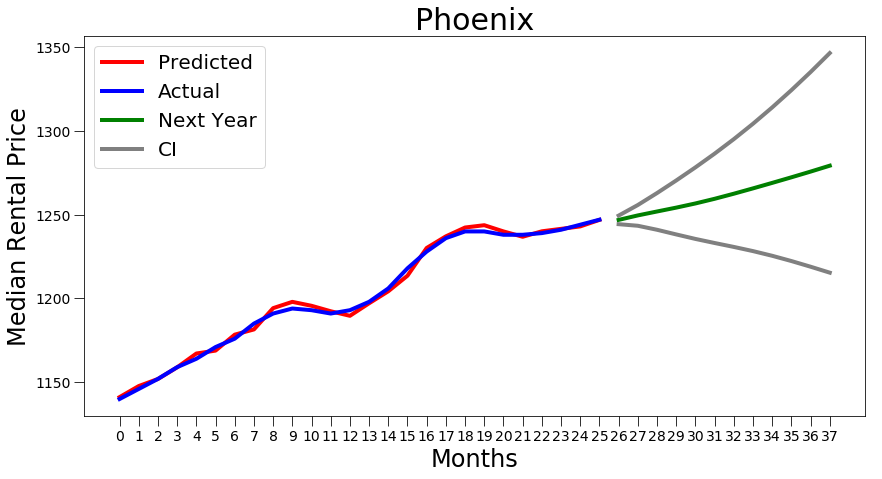

In [16]:
plt.figure(figsize = (14,7))
x = np.arange(0, 38, 1)
# create an index for each tick position
predict_x = [i for i in range(26, len(x))]
xi = [i for i in range(0, len(x)-12)]
y = predicts
z = expects_median

plt.plot(xi, y, linestyle='-', color='r', label='Predicted', linewidth=4.0)
plt.plot(xi, z, linestyle='-', color='b', label='Actual', linewidth=4.0)
plt.plot(predict_x, next_year, linestyle='-', color='green', label='Next Year', linewidth=4.0)

# confidence intervals
plt.plot(predict_x, lower_ci, linestyle='-', color='gray', label='CI', linewidth=4.0)
plt.plot(predict_x, upper_ci, linestyle='-', color='gray', linewidth=4.0)

plt.xlabel('Months', fontsize=24)
plt.ylabel('Median Rental Price', fontsize=24) 
plt.xticks(x, x,)
plt.tick_params('x', colors='black', size = 10, labelsize = 14)
plt.tick_params('y', colors='black', size = 10, labelsize = 14)
plt.title(city, fontsize=30)
plt.legend(prop={'size': 20}) 
plt.show()